DATA PRE PROCESSING

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import tensorflow as tf
print(tf.__version__)


2.7.0


In [2]:
!pip install tweet-preprocessor

In [3]:
import numpy as np
import pandas as pd

In [4]:
import re
import nltk
import preprocessor as preproc
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISAA_DATASET/kaggle_parsed_dataset.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISAA_DATASET/twitter_racism_parsed_dataset.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISAA_DATASET/twitter_sexism_parsed_dataset.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISAA_DATASET/data.csv')
print(len(df1))
print(len(df2))
print(len(df3))
print(len(df4))

8799
13471
14881
24783


5993
11501
11501


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e392ad1d0>]],
      dtype=object)

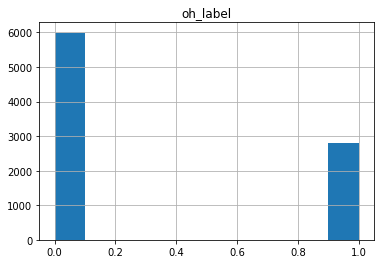

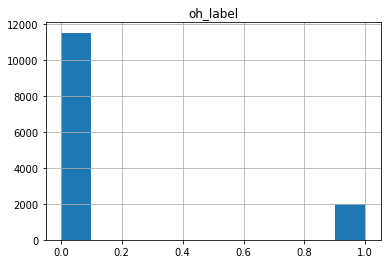

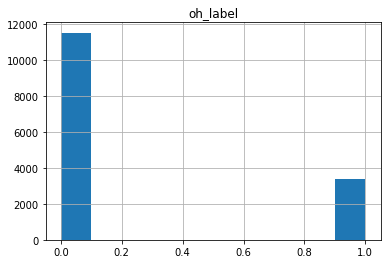

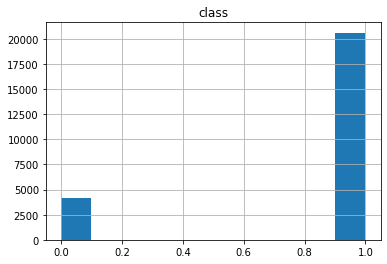

In [8]:
df1.hist(column="oh_label")
print(len(df1.query('oh_label == 0')))
df2.hist(column="oh_label")
print(len(df2.query('oh_label == 0')))
df3.hist(column="oh_label")
print(len(df3.query('oh_label == 0')))
df4.hist(column="class")

In [9]:
print(df4.head())
print(len(df4['class']))

   Unnamed: 0  class                                              tweet
0           0      0  !!! RT @mayasolovely: As a woman you shouldn't...
1           1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2           2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3           3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4           4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
24783


In [10]:
df1 = df1[df1['Text'].str.split().str.len().lt(50)]
df2 = df2[df2['Text'].str.split().str.len().lt(50)]
df3 = df3[df3['Text'].str.split().str.len().lt(50)]
df4 = df4[df4['tweet'].str.split().str.len().lt(50)]

print(len(df1))
print(len(df2))
print(len(df3))
print(len(df4))

7552
13471
14880
24782


32216
28467
60683


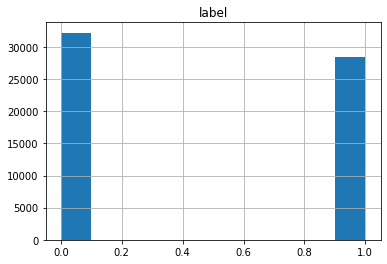

In [11]:
A = np.concatenate([df1['Text'].values, df2['Text'].values, df3['Text'].values, df4['tweet'].values],axis=0)
B = np.concatenate([df1['oh_label'].values, df2['oh_label'].values, df3['oh_label'].values, df4['class'].values],axis=0)
df = pd.DataFrame()
df['text'] = A.tolist()
df['label'] = B.tolist()
df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
df.hist(column="label")
print(len(df.query('label == 0')))
print(len(df.query('label == 1')))
print(len(df))

32216
28467


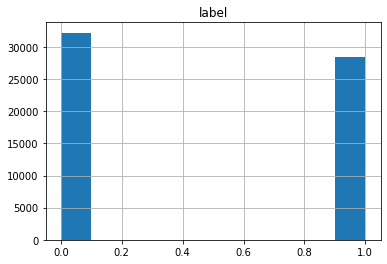

In [12]:
#df = df.drop(df.query('label == 0').sample(frac=.71).index)
df.hist(column="label")
print(len(df.query('label == 0')))
print(len(df.query('label == 1')))

In [13]:
#Dataset Cleaning

import preprocessor as p
ps = PorterStemmer()

#Clean the text
def regexCleaning(text):
  text = p.clean(text)
  text = re.sub('[^a-zA-Z]| {2,}',' ',text)
  text = text.lower()
  text = text.split()
  text = [ps.stem(word) for word in text if word not in stop_words]
  text = ' '.join(text)
  if(len(text)):
    return text
  else:
    pass

In [14]:
X = df.iloc[:,0].values
y = df.iloc[:,1].values

print(X.shape)
print(y.shape)

X_cleaned = []
y_cleaned = []
for index,tweet in enumerate(X):
  cleaned_tweet = regexCleaning(tweet)
  if(cleaned_tweet):
    X_cleaned.append(cleaned_tweet)
    y_cleaned.append(y[index])

X_cleaned = np.asarray(X_cleaned)
y_cleaned = np.asarray(y_cleaned)

(60683,)
(60683,)


In [15]:
indices = np.arange(X_cleaned.shape[0])
np.random.shuffle(indices)
X_cleaned = X_cleaned[indices]
y_cleaned = y_cleaned[indices]

print(X_cleaned.shape)
print(y_cleaned.shape)

(59881,)
(59881,)


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 50
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_cleaned)
sequences = tokenizer.texts_to_sequences(X_cleaned)
word_index = tokenizer.word_index
print("Number of unique tokens are: ",len(word_index))
X_padded = pad_sequences(sequences, maxlen=maxlen, truncating="post", padding="post")

Number of unique tokens are:  23471


In [17]:
X = X_padded
y = y_cleaned
print(X.shape)
print(y.shape)

(59881, 50)
(59881,)


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_train)

[[ 282   28   50 ...    0    0    0]
 [  49  548   43 ...    0    0    0]
 [  87   35 1204 ...    0    0    0]
 ...
 [ 194 1053  596 ...    0    0    0]
 [3900 2020  609 ...    0    0    0]
 [  45  134    1 ...    0    0    0]]


In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(41916, 50)
(41916,)
(8982, 50)
(8982,)
(8983, 50)
(8983,)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=4, 
)

model = Sequential()
model.add(Embedding(max_words, 50, input_length=maxlen))
model.add(LSTM(100, return_sequences = True, dropout=0.5))
model.add(LSTM(50, dropout=0.4))
model.add(Dense(30))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            1000000   
                                                                 
 lstm_4 (LSTM)               (None, 50, 100)           60400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 30)                1530      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,092,161
Trainable params: 1,092,161
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=64, callbacks=[early_stopping])

Epoch 1/15
655/655 [==============================] - 26s 34ms/step - loss: 0.6919 - accuracy: 0.5261 - val_loss: 0.6925 - val_accuracy: 0.5188
Epoch 2/15
655/655 [==============================] - 21s 32ms/step - loss: 0.6919 - accuracy: 0.5269 - val_loss: 0.6927 - val_accuracy: 0.5188
Epoch 3/15
655/655 [==============================] - 21s 32ms/step - loss: 0.5921 - accuracy: 0.6705 - val_loss: 0.4964 - val_accuracy: 0.7921
Epoch 4/15
655/655 [==============================] - 21s 32ms/step - loss: 0.4878 - accuracy: 0.7999 - val_loss: 0.4639 - val_accuracy: 0.8012
Epoch 5/15
655/655 [==============================] - 21s 32ms/step - loss: 0.4572 - accuracy: 0.8167 - val_loss: 0.4604 - val_accuracy: 0.8181
Epoch 6/15
655/655 [==============================] - 21s 32ms/step - loss: 0.4512 - accuracy: 0.8068 - val_loss: 0.4393 - val_accuracy: 0.8098
Epoch 7/15
655/655 [==============================] - 21s 32ms/step - loss: 0.4299 - accuracy: 0.8297 - val_loss: 0.4436 - val_accuracy:

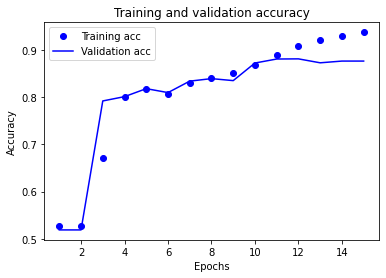

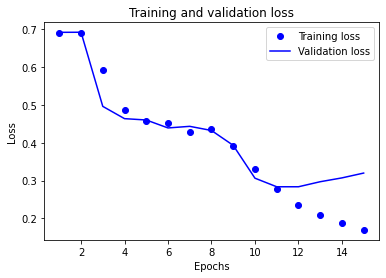

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
import io, json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

print("Saved model to disk")

Saved model to disk


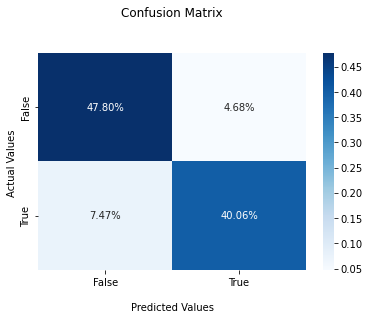

0.8785348474727233


In [31]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns


y_pred=(model.predict(X_test) > 0.5).astype("int32")
cf_matrix = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
print(accuracy_score(y_test,y_pred))

In [ ]:
def test_output(sentence):
  sentence = regexCleaning(sentence)
  sentence = [sentence]
  seq = tokenizer.texts_to_sequences(sentence)
  seq_padded = pad_sequences(seq, maxlen=maxlen, truncating="post", padding="post")
  prediction = (model.predict(seq_padded) > 0.5).astype("int32")
  print(prediction)
  if(prediction == 1 ):
    return "offensive"
  else:
    return "non offensive"

In [ ]:
print(test_output("Just get lost you idiot"))

[[1]]
offensive
